# Technical analysis

In this notebook, we will do basic technical analysis on decentralised exchange price data.

Technical analysis is a trading discipline employed to evaluate investments and
identify trading opportunities by analyzing statistical trends gathered from trading activity,
such as price movement and volume. [More information](https://www.investopedia.com/terms/t/technicalanalysis.asp>).

We will

* Create interactive charts (zoom, pan, etc.)

* Download daily candle data for all pairs (several dozens of megabytes)

* Extract data for ETH-USDC pair on Uniswap v2

* Draw some standard technical analysis charts to identify if ETH-USDC pair is overbought or ovesold

* Plot technical charts using Cufflinks library

[Cufflinks](https://github.com/santosjorge/cufflinks) is a library build on the top of Plotly.
It gives good out of the box tools for quantative finance and technical analysis.
Cufflinks builds on the top the top of Plotly, as introduced in the previous chapter.

## Setup

First let's install Capitalgram package, the package dependencies and initialise our dataset client.
This might take 5 minutes in a fresh environment.

In [1]:
from tradingstrategy.client import Client
client = await Client.create_jupyter_lite_client(api_key=globals().get("api_key",None))
if client==None:
    api_key=await input("Please enter an api key then re-run the notebook")


No existing Trading Strategy configuration found in /home/pyodide/.tradingstrategy/settings.json. Making config from keyword parameters.
Testing out API key: secret-token:tradingstra
The server replied accepted our API key and sent the following greetings:
Server version: 0.1
Message of the day: Han shot first
The API key setup complete.


## Fetch data

Let's download 1 day (24h) candles to all trading pairs. This dataset is several dozens of megabytes.
You should see a progress bar during the download.

**Note**: We could also query live candle datasets for trading pairs we are interested in.
However, the bundled dataset is faster for the future analysis, as after the download
it will have all candles cached in your local notebook environment.

In [10]:
from tradingstrategy.timebucket import TimeBucket

# Download all 24h candles as Parquet columnar data
all_candles_dataframe = client.fetch_all_candles(TimeBucket.d1).to_pandas()
pairs=client.fetch_pair_universe().to_pandas()
exchanges=client.fetch_exchange_universe()

Let's pick one pair, ETH-USDC on Uniswap v2, from the dataset to analyse.

In [11]:
import pandas as pd

from tradingstrategy.chain import ChainId
exchange_id=exchanges.get_by_chain_and_slug(ChainId.ethereum,"pancakeswap").exchange_id
# select the pair ID by the tokens used and the exchange
pair_id = pairs.query("token0_symbol == 'ETH' & token1_symbol=='USDC' & exchange_id==@exchange_id").iloc[0]['pair_id']
eth_usdc_pair: pd.DataFrame = all_candles_dataframe.query("pair_id == @pair_id")

print(f"PancakeSwap ETH-USDC has {len(eth_usdc_pair)} daily candles")
# Because of swap exchange nature, we have separate volumes for buy and sell. We will
# combine this to generic `volume` column
eth_usdc_pair["volume"] = eth_usdc_pair["buy_volume"] + eth_usdc_pair["sell_volume"]

PancakeSwap ETH-USDC has 416 daily candles


## Volume chart

The main benefit is having the trade volume (V in OHLCV) automatically rendered in the diagrams,
 as you would have on any trading view.

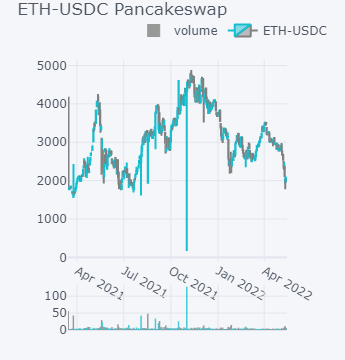

In [12]:
import cufflinks as cf

# Needed for Sphinx/Jupyter/Pycharm compatibility
# See https://github.com/santosjorge/cufflinks/issues/267
cf.go_offline()

# Tell Cufflinks which data column to use as X axis for the daigram
eth_usdc_pair = eth_usdc_pair.set_axis(eth_usdc_pair["timestamp"], axis="index")

quant_chart = cf.QuantFig(
    eth_usdc_pair,
    title='ETH-USDC Pancakeswap',
    legend='top',
    name='ETH-USDC')
quant_chart.add_volume()
quant_chart.iplot()

## MACD

MACD, short for moving average convergence/divergence,
is a trading indicator used in technical analysis of stock price.
It is designed to reveal changes in the strength, direction, momentum,
 and duration of a trend in an assets's price.
 [Read more](https://en.wikipedia.org/wiki/MACD).

Below we plot MACD for our ETH-USDC pair.

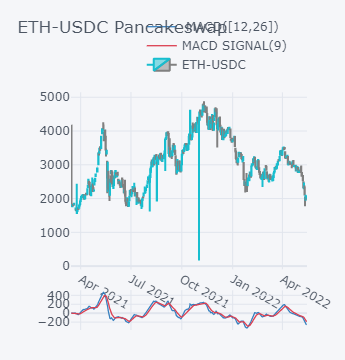

In [13]:
quant_chart = cf.QuantFig(
    eth_usdc_pair,
    title='ETH-USDC Pancakeswap',
    legend='top',
    name='ETH-USDC')
quant_chart.add_macd()
quant_chart.iplot()


## RSI

The relative strength index (RSI) is a technical indicator used in the analysis of financial markets.
It is intended to chart the current and historical strength or weakness of a stock or market based on the
closing prices of a recent trading period. The indicator should not be confused with relative strength.
[Read more](https://en.wikipedia.org/wiki/Relative_strength_index).

Below we plot ESI for our ETH-USDC pair.

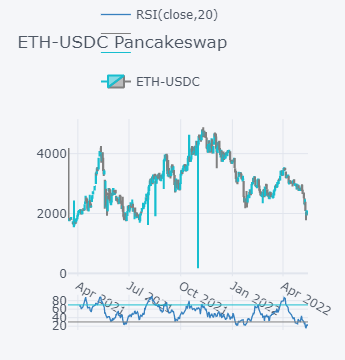

In [14]:
quant_chart = cf.QuantFig(
    eth_usdc_pair,
    title='ETH-USDC Pancakeswap',
    legend='top',
    name='ETH-USDC')
quant_chart.add_rsi()
quant_chart.iplot()

## Bollinger Bands

Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time of a
financial instrument. Bollinger Bands display a graphical band (the envelope maximum and minimum of moving averages,
and volatility (expressed by the width of the envelope) in one two-dimensional chart.
[Read more](https://en.wikipedia.org/wiki/Bollinger_Bands).

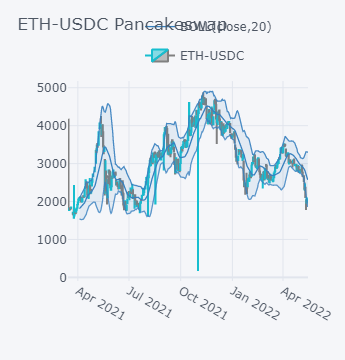

In [15]:
quant_chart = cf.QuantFig(
    eth_usdc_pair,
    title='ETH-USDC Pancakeswap',
    legend='top',
    name='ETH-USDC')
quant_chart.add_bollinger_bands()
quant_chart.iplot()

Onwards! Next we will simulate trading based on our technical analysis and signals.